<a href="https://colab.research.google.com/github/vilsonrodrigues/Projeto_Orientacao_Academica_LoP/blob/main/Projeto_Orientacao_Academica_LoP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por @vilsonrodrigues



# <center>Projeto de Orientação Acadêmica do LoP




<img src='https://ufrn.br/resources/documentos/identidadevisual/logotipo/logotipo_flat.png'>

## Parte I - Apresentação do Problema
### [1. Apresentação do Problema](#apresentacao)
## Parte II - Preparativos Iniciais
### [1. Bibliotecas](#bibliotecas)
### [2. Classe](#classe)
### [3. Funções](#funcoes)
### [4. Leitura da Base](#leiturabase)
## Parte III - Desenvolvimento
### [1. Entendimento de Negócio](#negocio)
### [2. Entendimento de Dados](#enten_dados)
### [3. Preparação de Dados](#preparo)
### [4. Métricas de Avaliação](#metricas)
### [5. Modelagem](#modelagem)
### [6. Avaliação de Modelo](#avaliacao)
### [7. Conclusão e Recomendações](#conclusao)
### [8. Implantação de Modelos](#implantacao)


# Parte I - Apresentação do Problema

### Meta

### Fonte dos Dados

### Referência
Hands On: Machine Learning with Scikit-Learning e Tensor Flow



# Parte II - Preparativos Iniciais

## 1. Bibliotecas
<a id='bibliotecas'></a>
#### [1.1 Instalações](#instalacao)
#### [1.2 Importações](#importacao)


### 1.1. Instalação
<a id='instalacao'></a>

In [ ]:
!pip install pandas -U
!pip install scikit-learn -U
!pip install numpy -U
!pip install joblib==0.14.1
!conda install xgboost -c conda-forge --yes

### 1.2. Importação
<a id='importacao'></a>

In [ ]:
import pandas as pd
import numpy as np

#Persistência em disco
import joblib
import pickle

#Visualização
import seaborn as sns
import matplotlib.pyplot as plt

#Transformadores e Modelador
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler
from sklearn.base              import BaseEstimator, TransformerMixin

#Selecao de modelo
from sklearn.model_selection   import train_test_split
from sklearn.model_selection   import KFold
from sklearn.model_selection   import cross_val_score
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

#Metricas
from sklearn.metrics           import classification_report
from sklearn.metrics           import confusion_matrix
from sklearn.metrics           import make_scorer
from sklearn.metrics           import accuracy_score
from sklearn.metrics           import f1_score
from sklearn.metrics           import recall_score
from sklearn.metrics           import precision_score

#Classificadores
from sklearn.ensemble          import RandomForestClassifier
from xgboost                   import XGBClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neural_network    import MLPClassifier

#modo não-perturbe
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import json
import urllib3
urllib3.disable_warnings()
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

##2. Classe
<a id='classe'></a>


Classe para realizar x-ação

##3. Funções
<a id='funcoes'></a>

Função de leitura de arquivos txt

In [ ]:
def read_txt(path):
  with open(path,'r') as file:
    return file.read()

Função de consulta no LoP

In [ ]:
def lop_consult(url):
  http = urllib3.PoolManager()
  req = http.request('GET',url)
  if req.status == 200:
    return pd.read_json(req.data, orient = 'RECORDS', encoding = 'utf-8').copy()
  else: 
    return False

Função para obter todas as classes do LoP a partir de uma lista de professores

In [ ]:
def lop_class(df_teacher = pd.DataFrame()):
  #Essa função se passar por cópia o df_teacher se torna desnecessário fazer a requisição de todas os professores, e evitando fazer varias consultas
  #Dataframe onde será armazenado todas as turmas
  df_class = pd.DataFrame()
  if df_teacher.empty == True:
    #Formação da url de consulta para saber os professores cadastrados no LoP
    url_teacher = endpoint_teacher + key
    #Realizando a consulta no LoP
    df_teacher = lop_consult(url_teacher)#id, email, name
  #O laço faz uma varredura das turmas de cada professor e por fim armazena em um dataframe de turmas
  for id_teacher in df_teacher.id:
    #O LoP.v2 foi desenvolvido em 2019, então temos que capturar as turmas entre 2019 e o ano atual
    current_year = datetime.now().year
    for year in range(2019, current_year + 1):
      #Por fim precisamos do semestre que deve ser 1 ou 2
      for semester in range(1,3): 
        #Url de consulta de classes
        url_class = endpoint_class + id_teacher + '?year=' + str(year) + '&semester=' + str(semester) + '&key=' + key 
        #Dataframe provisório necessário para capturar o tamanho e saber quantas turmas esse professor tem que estar associado
        df_prov = lop_consult(url_class)
        #Inserindo o id do professor no dataframe de turmas
        df_prov['id_teacher'] = id_teacher
        #Adicionando turmas conforme novas consultas
        df_class = df_class.append(df_prov, ignore_index=True).copy()#id, name, code, year, semester, id_teacher
  #Renomeando colunas com nomes semelhantes em todos os DF
  df_class.rename(columns={'id':'id_class','name':'name_class'}, inplace = True)
  return df_class

Função para obter todas as submissões a partir de uma lista de turmas

In [ ]:
def lop_submission(df_class = pd.DataFrame()):
  #Essa função se passar por cópia o df_class se torna desnecessário fazer a requisição de todas as turmas usando a função lop_class()
  #Dataframe onde serão armazenados todas as submissões 
  df_submission = pd.DataFrame()  
  if df_class.empty == True:
    df_class = lop_class()  
  #Obtem todas as submissões da lista de turmas passadas
  for id_class in df_class.id_class:
    #Url da consulta as submissões
    url_submission = endpoint_submission + id_class + '/submission?key=' + key
    #Dataframe provisório que vai armazenar o resultado da consulta
    df_prov = lop_consult(url_submission)
    #Inserindo o id_class no dataframe de consultas
    df_prov['id_class'] = id_class
    #Adicionando submissões conforme consultas
    df_submission = df_submission.append(df_prov, ignore_index=True).copy()
  return df_submission

Função para obter dados das questões cadastradas no LoP

In [ ]:
def lop_question():
  url_question = endpoint_question + key
  df_lop_question = lop_consult(url_question)
  df_lop_question.rename(columns = {'id':'id_question','title':'question'}, inplace = True)
  return df_lop_question

Função que transforma os dados das questões extraídas do LoP, assim podemos saber a dificuldade de uma questão, que pode estar associada a uma ou mais listas

In [ ]:
def question_data(df_question = pd.DataFrame()):
  #Essa função se passar por cópia o df_question se torna desnecessário fazer a requisição de todas as turmas usando a função lop_question()
  #Dataframes onde serão armazenados todas as questões transformadas
  df_list_data = pd.DataFrame()  
  df_tag_data = pd.DataFrame()  
  df_question_data = pd.DataFrame()  
  if df_question.empty == True:
    df_question = lop_question()
  for question,lists,tags,difficulty in zip(df_question.question,df_question.lists,df_question.tags,df_question.difficulty):
    #Cada registro do json pode ficar com mais de uma lista associada a uma questão, por isso a necessidade de extrair
    df_prov_lists  = pd.DataFrame(json.loads(str(lists).replace("'",'"')))
    #df_prov_lists.rename(columns = {'id':'id_list','title':'list'}, inplace = True)
    #Inserindo a questão associada
    df_prov_lists['question'] = question
    df_prov_lists['difficulty'] = difficulty
    df_list_data = df_list_data.append(df_prov_lists, ignore_index = True).copy()
    #Extraindo as tags, que vão dizer o conteudo associado
    df_prov_tags = pd.DataFrame(json.loads(str(tags).replace("'",'"'))).T
    #Inserindo a questão associada
    df_prov_tags['question'] = question    
    df_tag_data = df_tag_data.append(df_prov_tags, ignore_index = True).copy()
  
  df_list_data.rename(columns = {'id':'id_list','title':'list'}, inplace = True)
  #df_list_data['difficulty'] = df_list_data['difficulty'].astype('int')
  columns_tags = ['question']
  for i in range(len(df_tag_data.columns)-1): columns_tags.append('tag'+str(i+1))
  df_tag_data.columns = columns_tags
  return pd.merge(df_list_data, df_tag_data, on = 'question', how = 'outer').fillna(0).copy()

Função para avaliar a perfomance por lista

In [ ]:
def performance_list(df_submission):  
  #Essa função necessita receber as submissões de uma turma ---------- depois podemos incrementar essa função ao ter uma turma associada e agrupar por elas
  #Me traz as porcentagens maximas de acerto por questão
  df_performance_list = df_submission.groupby(['user','list','question'])['hitPercentage'].max().reset_index()
  #Soma as porcentagens de uma lista unica
  df_performance_list = df_performance_list.groupby(['user','list'])['hitPercentage'].sum().reset_index()
  #Renomeando para melhorar entendimento
  df_performance_list.rename(columns={'hitPercentage':'totalHitPercentage'}, inplace = True)
  #Usando a função de dados de questão para ter informações sobre que questões estão associadas a lista
  df_question_data = question_data()
  #Agrupa por lista e questão para ter apenas uma questão de cada, a operação não importa muito, apenas existe para completar o agrupamento --------- pode ser uma boa trocar por drop_duplicates
  df_question_data = df_question_data.groupby(['list','question'])['id_list'].count().reset_index()
  #Conta quantas questões tem por lista
  df_question_data = df_question_data.groupby(['list'])['question'].count().reset_index()
  #Renomeando lista
  df_question_data.rename(columns={'question':'totalQuestionsList'}, inplace = True)
  #Merge
  df_performance_list = df_performance_list.merge(df_question_data, on = 'list')
  #Média de acerto por lista
  df_performance_list['mediaList'] = df_performance_list['totalHitPercentage'] / df_performance_list['totalQuestionsList']
  return df_performance_list

Função do gráfico de barras que, por lista, faz a contagem de quem fez mais e menos de 70% da lista. Necessita de passar a performance do aluno por lista

In [ ]:
def graph_more_less_70_list_class(df_performance_list):
  #Aqui eu conto, por lista, quantos tiraram mais de 70% de acerto
  df_more70 = df_performance_list[df_performance_list['mediaList'] >= 70.0].groupby('list')['mediaList'].count().reset_index(name='more70')
  #E nesse conta quantos tiveram menos de 70%
  df_less70 = df_performance_list[df_performance_list['mediaList'] < 70.0].groupby('list')['mediaList'].count().reset_index(name='less70')
  #Aqui junta ambos os dataframes, usando o outer, que, se por acaso não tiver uma ocorrência de uma lista em um dos dataframes, mesmo assim eles vão ser adicionados, é união dos conjuntos
  df_less_more_70 = pd.merge(df_more70, df_less70, on = 'list', how = 'outer')
  #E, se caso acontecer a situação de um não existir, substituimos o nan por 0
  df_less_more_70.replace(np.NaN, 0, inplace = True)
  return df_less_more_70.to_json('df_less_more_70.json',force_ascii=False, orient='records') #############3 por hora essa função tamebm esta realizando downlaod

Função do grafico de distribuição de notas por lista. Necessita da performance do  

In [ ]:
def graph_distribution_notes_list(df_performance_list):
  #Agrupa por lista, e conta as ocorrências
  return df_performance_list.groupby('list')['mediaList'].apply(lambda group: group.values.tolist()).to_json('df_distribuition_notes_list.json',force_ascii=False,orient='index')

Não mexer

In [ ]:
#df_teste.groupby('user')[['list','mediaList']].apply(lambda group: group.values.tolist()).to_json(force_ascii=False).replace('{"','{"students":[{"user":"').replace(":[[",',"lists":[{"list":').replace(":]],",',"lists":}]').replace(']],"','}],"user":"')

Testes

In [ ]:
turma = ['66baea8b-9ee0-4297-a218-a76a35e9dca4']
df_subs = lop_submission(pd.DataFrame(turma, columns = ['id_class']))

**Por hora descondirem essa função**

In [ ]:
'''
def avaliar_modelos(df, hyperparameters):

  #Dicionários
  model_param_disciplinas = {}
  best_acc_disciplinas = {}
  scoring_disciplinas = {}
  #feature_importances_disciplinas = {}

  #Seleciona o codigo de cada disciplina no dataframe, --alteravel--
  lista_disciplinas = df["disciplina"].unique()  

  #Verifica se esta vazio
  if lista_disciplinas is None:
	  return None

  #Convertendo categorias do target de string para numerico (0,1)
  df["situacao_categoria"] = pd.Categorical(df["situacao"]).codes

  #Pipeline para transformar em categoria e verificar melhores parametros
  pipeline_transform = Pipeline(steps = [('num_pipeline', NumericalTransformer()),
                                         ('fs',SelectKBest(chi2)),
                                         ('sc',StandardScaler()),
                                         ('clf',XGBClassifier())
                               ])

  #Grid para testar todos os parâmetros                               
  grid_search = GridSearchCV(
                          estimator = pipeline_transform, 
                          param_grid = hyperparameters,
                          cv= 5,
                          scoring = {'Accuracy': make_scorer(accuracy_score)},
                          #scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score), "F1":"f1", "Recall":"recall", "Precision":"precision"},
                          return_train_score=True,
                          n_jobs=-1,#indica o numero de processos em paralelo, -1 significa usar todos
                          refit='Accuracy')


  #itera sobre a lista de disciplinas
  for disciplina in lista_disciplinas:
    data_iter = df.loc[df["disciplina"].str.contains(disciplina),:]
    
    #Treinando Grid
    best_model = grid_search.fit(data_iter.drop(columns = ["disciplina","situacao_categoria"]), data_iter["situacao_categoria"])
 
    #Extraindo informações do treino
    param_modelo = best_model.best_params_
    model_param_disciplinas[disciplina] = param_modelo['clf']
    best_acc_disciplinas[disciplina] = best_model.best_score_

    #Resultado de metricas
    result = pd.DataFrame(best_model.cv_results_)
    result = result[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy','rank_test_Accuracy']].copy()
    result["std_ratio"] = result.std_test_Accuracy/result.std_train_Accuracy
    result = result.sort_values(by="rank_test_Accuracy",ascending=True)    
    scoring_disciplinas[disciplina] = result.iloc[0,:]

    #Características mais importantes
    #feature_importances_disciplinas[disciplina] = grid.best_estimator_.feature_importances_
    
    #Salvando modelo
    joblib.dump(best_model, 'modelo_' + disciplina + '.pkl')


  #Transformando o dicionário para Dataframe
  df_best_acc = pd.DataFrame.from_dict(best_acc_disciplinas, orient="index")
  df_best_acc.columns = ["accuracy"]
  df_scor_disc = pd.DataFrame.from_dict(scoring_disciplinas, orient="index")

  #Concatenando DataFrames
  df_relatorio = pd.concat([df_best_acc, df_scor_disc], axis=1, sort=False)

  return (df_relatorio,model_param_disciplinas)

'''

##4. Leitura da Base
<a id='leiturabase'></a>

### Foi projetado para ter 4 tipos de consultas

* A primeira é para receber dados dos professores que estão resgistrados no sistema

* A segunda é para receber dados das turmas que estão registradas no sistema

* A terceira é para receber dados das submissões que estão registradas no sistema

* A quarta é para receber dados das questões que estão registradas no sistema

As consultas vão ser tornando acumulativas, com a segunda dependendo de dados da primeira, e a terceira dependendo de dados da primeira e segunda para o preenchimento da url de consulta. Todas as consultas dependem da key de acesso

Na consulta da class possui as depedências de: 
1. id_teacher, que é o id de um professor
2. year, que é o ano da turma 
3. semester, que é o semestre (1 ou 2) da turma

E na consulta de submission necessita do:
1. id_class, que é o id de uma turma.

Já a consulta de question e do teacher necessita apenas da key

As consultas serão feitas via protocolo HTTP usando o método Get e irão receber um JSON dos dados do LoP


### Estrutra das funções e suas dependências

Funções de coleta e transformações de dados 

- lop_class(), lop_question()
--- lop_submission()
------ question_data()
--------- performance_list()
------------ graph_more_less_70_list_class()
------------ graph_distribution_notes_list()

Funções de treinamento de modelos de Machine Learning

Leitura de endpoints e key

In [ ]:
key = read_txt('key.txt')
endpoint_teacher = read_txt('endpoint_teacher.txt')
endpoint_class = read_txt('endpoint_class.txt')
endpoint_submission = read_txt('endpoint_submission.txt')
endpoint_question = read_txt('endpoint_question.txt')

Consultando submissões a partir de uma lista de turmas

Vou pegar uma turma aleatoria afim de montar uma consulta

In [ ]:
turma = ['b5413cd7-4f61-4241-aad8-23740bab604f']

Necessita passar como DataFrame, então eu vou construir nesse formato exibido abaixo

In [ ]:
pd.DataFrame(['b5413cd7-4f61-4241-aad8-23740bab604f'], columns = ['id_class']).to_json(orient='records')

'[{"id_class":"b5413cd7-4f61-4241-aad8-23740bab604f"}]'

**A partir daqui ainda vai sofrer alterações**

#Parte III - Desenvolvimento
<a id='enten_dados'></a>


## 1. Entendimento de Dados
<a id='enten_dados'></a>

### [1.1 Descrição de Dados](#descricao)
### [1.2 Qualidade de Dados](#qualidade)
### [1.3 Exploração de Dados](#exploracao)

###1.1 Descrição de Dados
<a id='descricao'></a>


#### <center>Dataframe Submissões
| **Semestre** | **Número de atributos (colunas)** | **Número de Registros (linhas)** |
| --- | --- | --- |
| 2020.5 | xxxx | yyy |
| 2020.6 | yyyy | xxx |

#### <center>Dataframe Resultados em LOP
| **Semestre** | **Número de atributos (colunas)** | **Número de Registros (linhas)** |
| --- | --- | --- |
| 2020.5 | xxxx | yyyyy |


---

####Descrição do datafrane dos professores - Consulta embutida em lop_class()

<b>1. id_teacher</b> ID do professor no LoP

<b>2. email</b> Email do professor

<b>3. name_teacher</b> Nome do professor

--- 

####Descrição do dataframe das turmas - lop_class()

<b>1. id_teacher</b> ID do professor no LoP

<b>2. id_class</b> ID da turma

<b>3. name_class</b> Nome da turma

<b>4. code</b> Código de acesso a turma no LoP

<b>5. year</b> Ano em que a turma foi cadastrada

<b>6. semester</b> Semestre em que a turma foi cadastrada

---
####Descrição dos dataframe de Submissão - lop_submission()


<b>1. environment</b> Tipo de máquina

<b>2. hitPercentage</b> Porcentagem de acerto na questão

<b>3. language</b> Linguagem de programação usada

<b>4. char_change_number</b> Número de caracteres alterados

<b>5. timeConsuming</b> Tempo que passou na questão

<b>6. createdAt</b> Data e hora da submissão

<b>7. user</b> Nome e matrícula do aluno

<b>8. question</b> Nome da questão

<b>9. list</b> Nome da lista

<b>10. test</b> Nome da prova

<b>11. id_class</b> ID da turma em que o aluno está associado nessa submissão

---

####Descrição do dataframe das questões do LoP - lop_question()


<b>1. id_questao</b> ID da questão

<b>2. question</b> Nome da questão

<b>3. difficulty </b> Nível de dificuldade da questão (1-5)

<b>4. tags </b> Esse campo vem com um json que contem os assuntos em que essa questão está associada

<b>5. lists </b> Esse campo vem com um json que contem as listas que a questão está associada 

<b>6. tests</b> Esse campo vem com um json que contem as provas que a questão está associada 

---

####Descrição do dataframe de dados das questões - question_data()


<b>1. id_list</b> ID da lista

<b>2. list</b> Nome da lista

<b>3. question </b> Nome da questão

<b>4. difficulty </b> Nível de dificuldade da questão (1-5)

<b>5. tags </b> Em cada coluna com nome tag, terá um conteúdo associado a ela

---


####Descrição do dataframe de performance por lista - performance_list()


<b>1. user</b> Nome e matrícula do aluno

<b>2. list</b> Nome da lista

<b>3. totalHitPercentage </b> Soma de todos acertos de questões únicas

<b>4. totalQuestionsList </b> Número de questões por lista

<b>5. mediaList</b> Esse campo vem com um json que contem as provas que a questão está associada 

---

In [ ]:
df.select_dtypes(include=['int64','float64']).describe()

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

###1.2 Qualidade dos dados
<a id='qualidade'></a>

Nas submissões existem 2 tipos de associação que a questão pode ter, ser uma questão de lista ou ser de prova. Por isso existem valores nulos nos campos listQuestion_id e test_id

In [ ]:
1648+101714

103362

In [ ]:
sub20_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103362 entries, 0 to 103361
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  103362 non-null  object
 1   ip                  103362 non-null  object
 2   environment         103362 non-null  object
 3   language            103362 non-null  object
 4   char_change_number  103362 non-null  int64 
 5   timeConsuming       103362 non-null  int64 
 6   createdAt           103362 non-null  object
 7   listQuestions_id    101714 non-null  object
 8   test_id             1648 non-null    object
 9   question_id         103362 non-null  object
 10  user                103362 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [ ]:
sub20_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14707 entries, 0 to 14706
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  14707 non-null  object 
 1   ip                  14707 non-null  object 
 2   environment         14707 non-null  object 
 3   language            14707 non-null  object 
 4   char_change_number  14707 non-null  int64  
 5   timeConsuming       14707 non-null  int64  
 6   createdAt           14707 non-null  object 
 7   listQuestions_id    14707 non-null  object 
 8   test_id             0 non-null      float64
 9   question_id         14707 non-null  object 
 10  user                14707 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.2+ MB


In [ ]:
resultado20_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   matricula  200 non-null    int64  
 1   Nome       200 non-null    object 
 2   Unid. 1    200 non-null    float64
 3   Unid. 2    200 non-null    float64
 4   Unid. 3    200 non-null    float64
 5   Resultado  200 non-null    float64
 6   Sit.       200 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 11.1+ KB


Plotando correlação entre os dados númericos

In [ ]:
corr = df.corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

Falar um pouco da correlação

###1.3 Exploração de Dados
<a id='exploracao'></a>

In [ ]:
sub20_5.head()

,id,ip,environment,language,char_change_number,timeConsuming,createdAt,listQuestions_id,test_id,question_id,user
0,9e303858-43ab-4969-a4ca-d00ccc758598,192.168.1.8,desktop,javascript,220,1175423,2020-09-27T16:44:29.000Z,c6f3f5e5-0b0c-4396-92ba-d22d4125f555,None,d8f630b4-0ae8-4461-a08f-375b9f9265d4,"{'id': '48682d29-0cde-45f6-956a-6b482fc55196',..."
1,66eef061-ef84-4175-a8f4-7ab5d7ad4611,192.168.1.8,desktop,javascript,135,102620,2020-09-27T16:28:11.000Z,c6f3f5e5-0b0c-4396-92ba-d22d4125f555,None,c9225fd6-745a-41de-9dd0-56f56ebc4fff,"{'id': '48682d29-0cde-45f6-956a-6b482fc55196',..."
2,8a856d10-d332-44e4-b8e1-4b0cfdd63b94,192.168.0.103,desktop,javascript,12583,495419,2020-09-26T17:43:25.000Z,cf509a46-6a97-440e-a5c0-f7ba7537ef96,None,398cf3e2-6979-4745-a1a2-b451c8f2e400,"{'id': '7f2cb9ae-c23a-414c-bcef-a456e480018f',..."
3,7ec0d0bd-9477-42a9-8528-c73b067b8e92,c21fe468-8d38-43d4-8d0e-399e40d79109.local,desktop,javascript,521,207597,2020-09-26T01:08:14.000Z,0a2c49a2-482c-40d7-bc44-ee368f089560,None,0bafadf5-560a-4335-a8ad-ac103c4506f8,"{'id': '53de69c3-717c-43c5-942e-f96e507b92d9',..."
4,9774d73e-fa94-4d5e-a271-1f422c53098a,f65deeda-f071-4631-86bb-f2f994de2e84.local,desktop,javascript,738,48189,2020-09-25T15:14:17.000Z,cf509a46-6a97-440e-a5c0-f7ba7537ef96,None,cb34469b-0995-47c1-9ec0-0d72aadd8698,"{'id': '08a67c0a-d34f-46a9-be4a-f6940b7d278d',..."


In [ ]:
import datetime as dt

In [ ]:
sub20_5['createdAt'] = pd.to_datetime(sub20_5['createdAt'])
sub20_5['createdAt'] = sub20_5['createdAt'].dt.tz_localize(None)

In [ ]:
sub20_5['date'] = sub20_5['createdAt'].dt.date

In [ ]:
df_sub_por_data = sub20_5.groupby(['date'])['question_id'].count().reset_index()
df_sub_por_data.head()

,date,question_id
0,2020-06-16,2112
1,2020-06-17,6279
2,2020-06-18,7457
3,2020-06-19,4090
4,2020-06-20,893


<BarContainer object of 70 artists>

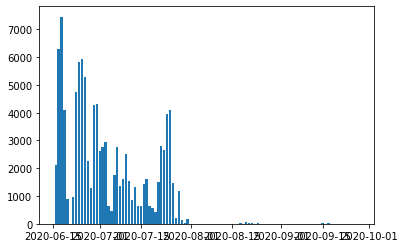

In [ ]:
plt.bar('date','question_id',data=df_sub_por_data)

##2. Preparação de Dados
<a id='preparo'></a>

##3. Métricas de Avaliação
<a id='metricas'></a>


#### <center>Métricas de Avaliação:
| Regressores | Classificadores
| --- | --- |
| <center>RMSE| <center>Matriz de Confusão |
| <center>MAE| <center>Acurácia |
| <center>R2| <center>Precisão / Recall / F1 |
| <center>R2 Ajustado| <center>AUC |




##4. Modelagem
<a id='#modelagem'></a>

Dicionário com hiper-parâmetros dos algoritmos preditivos

In [ ]:
hyperparameters = [
                  {"clf":[RandomForestClassifier()],
                  "clf__n_estimators": [100],
                  "clf__criterion": ["entropy"],
                  "clf__max_leaf_nodes": [64],
                  "clf__random_state": [42],
                  "fs__score_func":[chi2],
                  "fs__k":[4,9,15,30]
                  },
              
                  {"clf":[KNeighborsClassifier()],
                  "clf__n_neighbors":[5,9,11],
                  "fs__score_func":[chi2],
                  "fs__k":[4,9,15,30]                 
                  },
              
                  {"clf":[SVC()],
                  "clf__kernel":["sigmoid",'rbf'],
                  "clf__degree":[3,4],
                  "clf__gamma":[0.1,0.5,1],
                  "clf__C":[0.001,1,2],
                  "fs__score_func":[chi2],
                  "fs__k":[4,9,15,25,31] 
                  },
              
                  {"clf":[GaussianNB()]
                  },
              
                  {"clf":[MLPClassifier()],
                  "clf__hidden_layer_sizes": [(64,),(128,)],
                  "clf__activation": ["logistic"],
                  "clf__solver": ["sgd"],
                  "clf__max_iter": [500],
                  "clf__early_stopping":[True],
                  "clf__n_iter_no_change":[20],
                  "clf__validation_fraction":[0.20], 
                  },
              
                  {"clf":[XGBClassifier()],
                  "clf__n_estimators": [50,100],
                  "clf__max_depth": [4,6],
                  "clf__learning_rate": [0.001, 0.01,0.1],
                  "clf__random_state": [42],
                  "clf__subsample": [1.0],
                  "clf__colsample_bytree": [1.0],
                  "fs__score_func":[chi2],
                  "fs__k":[5,8,15,25,31]
                  }
  ]

##5. Avaliação dos Modelos
<a id='avaliacao'></a>

### [5.1 Chamada da Função](#chamada)
### [5.2 Teste de Modelo](#teste)

###5.1 Chamada da Função
<a id='chamada'></a>

In [ ]:
(df_relatorio, model_param_disciplinas) = avaliar_modelos(df, hyperparameters)

In [ ]:
df_relatorio.head()

In [ ]:
model_param_disciplinas

###5.2 Teste de Modelo
<a id='teste'></a>

Importando Modelo

In [ ]:
modelo_teste = joblib.load('modelo_.pkl')

Aplicando a transformação no teste

In [ ]:
num_transf = NumericalTransformer()
df_teste = model.transform(df)

In [ ]:
df_teste.head(2)

Realizando teste de um modelo, prevendo probabilidade de ser aprovado

In [ ]:
df_teste.iloc[42,:]

In [ ]:
df_teste.info()

In [ ]:
modelo_teste.predict(df_teste.iloc[42,:])

##6. Conclusão e Recomendações
<a id='conclusao'></a>

##7. Implantação de Modelos
<a id='implantacao'></a>